<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 22 - Aplicando Inteligência Artificial Para Prever a Média Mensal de Vendas</font></b></strong>

O que acha de trazer Inteligência Artificial para nossa conversa?

De todos os modelos que criamos até aqui no curso, nenhum deles pode ser considerado Inteligência Artificial, mas a partir de agora usaremos Deep Learning, atualmente a principalmente técnica de IA e o estado de arte para a solução de diversos problemas, incluindo previsões de séries temporais.

**Deep Learning - Modelo LSTM**

Os problemas de previsão de séries temporais são um tipo difícil de problema de modelagem preditiva. As séries temporais adicionam a complexidade de uma dependência de sequência entre as variáveis de entrada.

Um tipo poderoso de rede neural projetada para lidar com a dependência de sequência é chamado de Rede Neural Recorrente. A rede Long Short-Term Memory ou LSTM é um tipo de rede neural recorrente usada em aprendizado profundo que apresenta bons resultados, quando devidamente treinada.

Esta e as próximas aulas consideram que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.


Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.

!pip install -q -U watermark

You should consider upgrading via the 'c:\users\rodolfo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
# The new versions of Pandas and Matplotlib bring several warning messages to the developer. Let's disable this.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports for data manipulation
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports for data Vasualization
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports for metrics and model performance
import sklearn
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# Imports for formatting graphics
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
#Versions of packages used in this jupyter notebook
%reload_ext watermark
%watermark -a "Data Scientist Rodolfo Terra" --iversions

Author: Data Scientist Rodolfo Terra

numpy      : 1.19.2
keras      : 2.4.3
seaborn    : 0.11.0
matplotlib : 3.3.2
sklearn    : 0.23.2
sys        : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas     : 1.1.3
statsmodels: 0.12.0



## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

### Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [3]:
# Load the data
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [4]:
# shape
dados.shape

(9994, 21)

In [5]:
# Columns
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [6]:
# View the data
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [7]:
# Statistical Summart
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [8]:
# Chacking missing values - we have no missing values in the dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [9]:
# Adjusting the column names so that they are all lowercrase
dados.columns = map(str.lower, dados.columns)

In [10]:
# We will replace the spaces and dashes in the columnb names with '-'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [12]:
# Checking out 
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [13]:
# Separating data by category

df_tecnologia = dados.loc[dados['category'] == 'Technology']

Agora vamos preparar as séries temporais.

In [14]:
# Aggregating sales by order date
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()

In [15]:
# How is each dataset doing?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [16]:
# Putting the date as an index
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [17]:
# View the serie
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

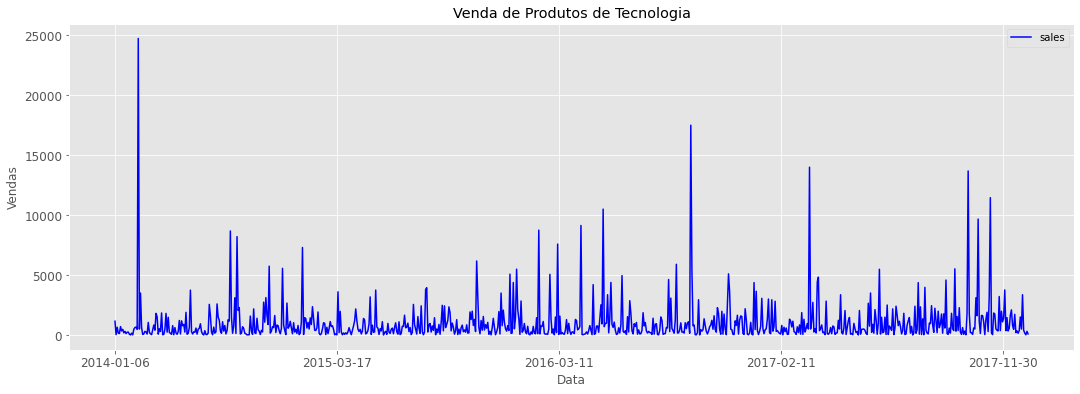

In [18]:
# Sale of technology Products
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo.

In [24]:
# Chaging the index type
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [25]:
# Checking the index type
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [26]:
# Checking the index type
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [27]:
# Checking the resulting type
type(media_vendas_tecnologia)

pandas.core.series.Series

In [28]:
# Resampling data for monthly frequency
# Using the average value of daily sales - we define the month as an index
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [29]:
# Checking the data
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

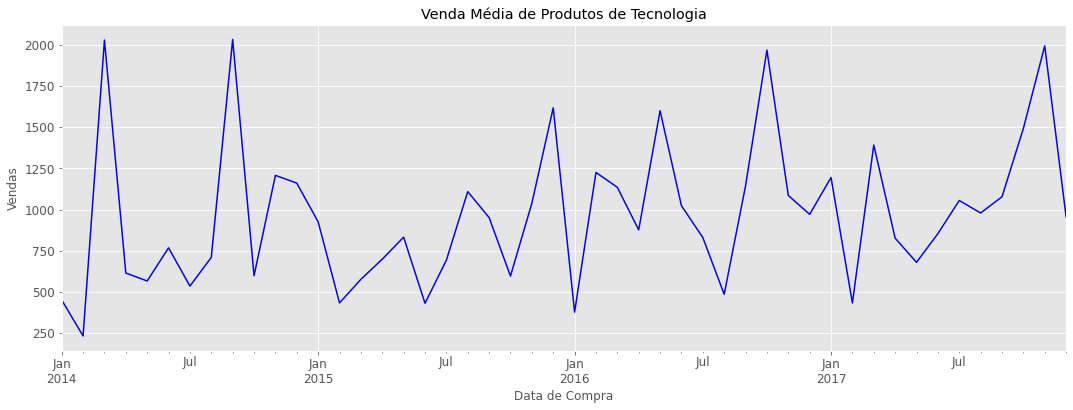

In [30]:
# Average Sale of technology Products
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

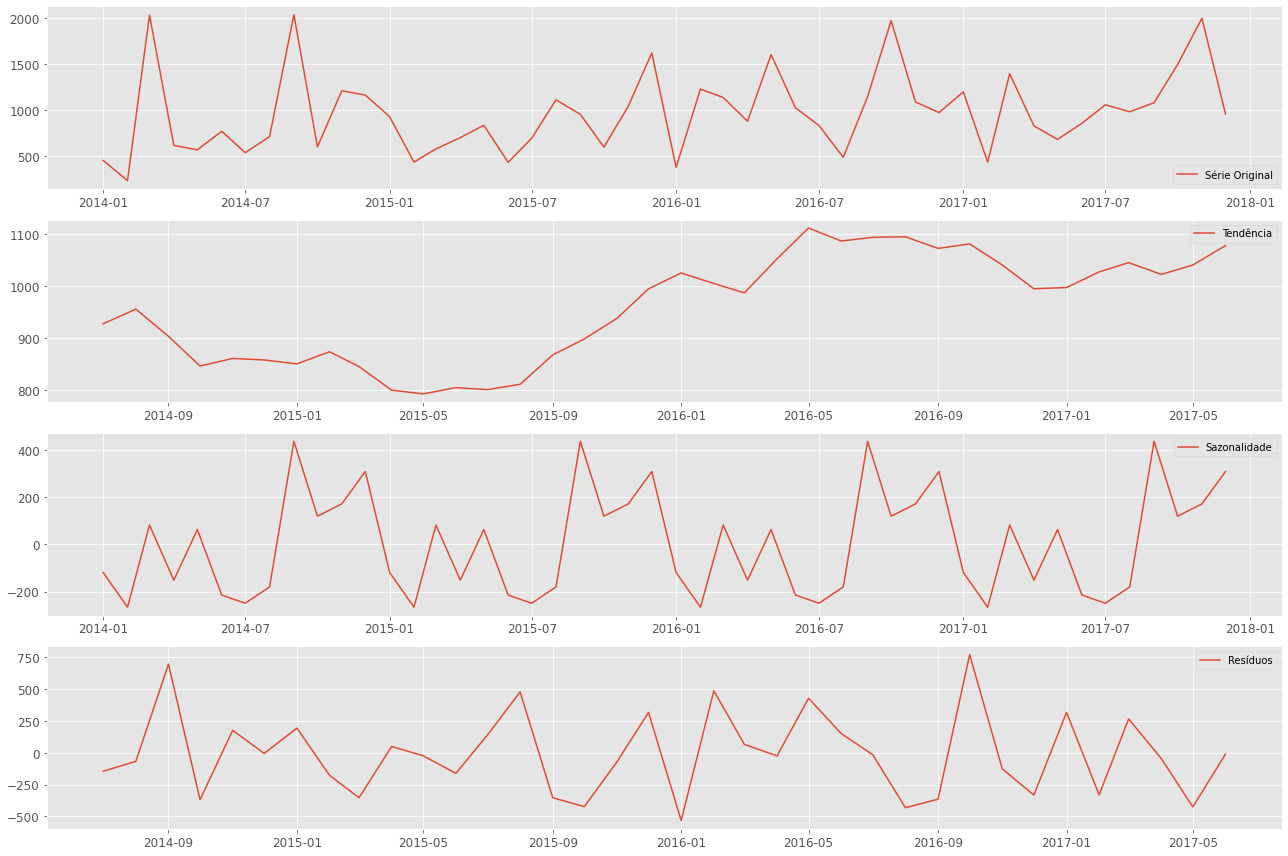

In [31]:
# Decomposition of the average salers time series of technology products
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [32]:
# Function to test stationarity
def testa_estacionaridade(serie):
    
    # Calculates mobile statistics
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot of mobile statistics
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Dickey-Fuller test:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Test
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatting the output
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])


    # Loop for each test output item
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Test the valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

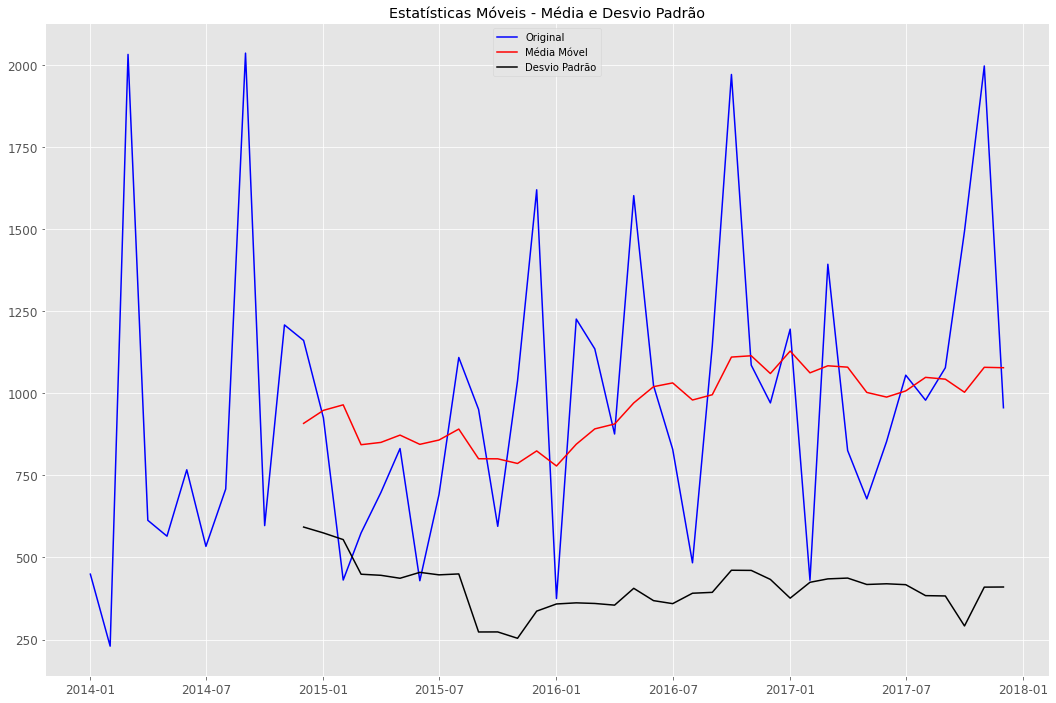


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [33]:
# Chacks whether the series is stationary
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os dados em Treino e Teste

Para a preparação dos dados, vamos alternar entre objetos NumPy e Pandas, usando o que cada um oferece de melhor. Fique atento a cada passo.

In [35]:
# Original Series
X = media_vendas_tecnologia

In [36]:
# The first 36 records in the series will be used as training data
X[:-12]

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
Freq: MS, Name: sales, dtype: float64

In [38]:
# The last 12 records in the series will be used as test data
X[-12:]

order_date
2017-01-01    1195.218071
2017-02-01     430.501714
2017-03-01    1392.859250
2017-04-01     825.559133
2017-05-01     678.329400
2017-06-01     853.055000
2017-07-01    1054.996636
2017-08-01     978.842333
2017-09-01    1077.704120
2017-10-01    1493.439227
2017-11-01    1996.750920
2017-12-01     955.865652
Freq: MS, Name: sales, dtype: float64

In [40]:
# Devision in training and testing
treino, teste = np.array(X[:-12]), np.array(X[-12:])

In [41]:
# Adjust the shape, because now we don't have a pd.Serie, 
#but Numpy array, which is needed to train the LSTM model
trainset = treino.reshape(-1,1)
testset = teste.reshape(-1,1)

In [42]:
len(trainset)

36

In [43]:
trainset

array([[ 449.04142857],
       [ 229.78714286],
       [2031.948375  ],
       [ 613.02893333],
       [ 564.69858824],
       [ 766.90590909],
       [ 533.60893333],
       [ 708.43538462],
       [2035.83813333],
       [ 596.9009    ],
       [1208.05632   ],
       [1160.73288889],
       [ 925.0708    ],
       [ 431.12125   ],
       [ 574.66233333],
       [ 697.5595    ],
       [ 831.64285714],
       [ 429.0244    ],
       [ 691.39773333],
       [1108.90228571],
       [ 950.8564    ],
       [ 594.71611111],
       [1037.98265217],
       [1619.63763636],
       [ 374.67106667],
       [1225.8914    ],
       [1135.15010526],
       [ 875.91188235],
       [1601.81616667],
       [1023.2595    ],
       [ 829.3125    ],
       [ 483.6201    ],
       [1144.1703    ],
       [1970.835875  ],
       [1085.64236   ],
       [ 970.55486957]])

In [44]:
len(testset)

12

In [45]:
testset

array([[1195.21807143],
       [ 430.50171429],
       [1392.85925   ],
       [ 825.55913333],
       [ 678.3294    ],
       [ 853.055     ],
       [1054.99663636],
       [ 978.84233333],
       [1077.70412   ],
       [1493.43922727],
       [1996.75092   ],
       [ 955.86565217]])

### Função Para o Cálculo da Acurácia

In [46]:
# Function
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

## Modelo LSTM

A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente (isso é explicado no Deep Learning Book).

Como tal, o modelo pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Em vez de neurônios, as redes LSTM possuem blocos de memória conectados através de camadas.

Um bloco possui componentes que o tornam mais inteligente que um neurônio clássico e uma memória para sequências recentes. Um bloco contém portas que gerenciam o estado e a saída do bloco. Um bloco opera sobre uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se são acionadas ou não, condicionando a mudança de estado e a adição de informações que fluem através do bloco.

Existem três tipos de portas dentro de uma unidade:

- Forget Gate: decide condicionalmente quais informações jogar fora do bloco.
- Input Gate: decide condicionalmente quais valores da entrada atualizar o estado da memória.
- Output Gate: decide condicionalmente o que enviar com base na entrada e na memória do bloco.

Cada unidade é como uma máquina de mini estado onde os portões das unidades têm pesos que são aprendidos durante o procedimento de treinamento.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.



In [47]:
# Create the scaler
scaler = MinMaxScaler()

In [48]:
# train this scaler in the training data (never in the fill dataset or test data)
scaler.fit(trainset)

MinMaxScaler()

In [49]:
# Apply the same scaler to training data
# (We don't need to apply it to the test data, as we will convert the forecast output before evaluating the model)
trainset = scaler.transform(trainset)

In [50]:
trainset.shape

(36, 1)

In [51]:
trainset

array([[0.12139983],
       [0.        ],
       [0.99784626],
       [0.21219877],
       [0.18543853],
       [0.29739956],
       [0.16822437],
       [0.26502477],
       [1.        ],
       [0.20326877],
       [0.54166199],
       [0.51545928],
       [0.38497454],
       [0.11147753],
       [0.1909554 ],
       [0.25900285],
       [0.33324403],
       [0.11031652],
       [0.25559112],
       [0.48676098],
       [0.39925188],
       [0.20205906],
       [0.44749318],
       [0.76955219],
       [0.08022139],
       [0.55153717],
       [0.50129424],
       [0.35775554],
       [0.75968454],
       [0.43934106],
       [0.33195373],
       [0.14054584],
       [0.50628867],
       [0.96400863],
       [0.47388209],
       [0.41015881]])

Aqui definimos os hiperparâmetros.

In [63]:
# Number of repetitions
n_rep = 20

#Number of epochs
num_epochs = 200

# Number of input (we will use 12 series to predict the next 12 series)
n_input = 12

# Length of output strings (in number of timesteps)
n_output = 12

# Here we are indicating that our series is univariate, therefore, only 1 resource
n_features = 1

# Number of time series samples in each batrch
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [55]:
# Generator
generator = TimeseriesGenerator(trainset, 
                               trainset,
                               length = n_output,
                               batch_size = size_batch)

Podemos agora criar o modelo.

Para começar a aplicação de Deep Learning ao nosso problema criaremos um modelo básico de LSTM que chamarei de LSTM Padrão.

Aqui está a principal diferença dos modelos de Deep Learning para outros métodos de previsão de séries temporais. Temos que criar o modelo com cada camada da rede neural.

Como trabalharemos com batches de dados da série que serão passados pela rede várias vezes, vamos criar o modelo e gerar os batches de dados a cada passada de um loop. As camadas de rede nada mais são que operações matemáticas.


In [68]:
# Creation and training of the Standard LSTM model

# We created a matrix filled with zeros that will receive the result of our model's predictions
resultado = np.zeros((n_input, n_rep))

# Loop
# We will repeat the training process 20 times and store all the results, so that we will use
# different samples. At the end, we take the average to find the predictions.
for i in range(n_rep):
    

    # The first step is to create the model, that is, an object of the Sequential () class of Keras
    modelo_lstm = Sequential()
    
    # We can now add the first layer of the network, or input layer.
    # This is the layer that receives the data.
    modelo_lstm.add(LSTM(50, activation = 'relu', input_shape = (n_input, n_features)))
    
    # The Dropout layer applies regularization to the network, removing some neurons and avoiding overfitting
    modelo_lstm.add(Dropout(0.10))

    
    # We add the first intermediate or hidden layer
    modelo_lstm.add(Dense(100, activation = 'relu'))

    
    # We add the second middle or hidden layer
    modelo_lstm.add(Dense(100, activation = 'relu'))

    
    # We added the output layer and all we need is 1 neuron as we are only predicting 1 value.
    modelo_lstm.add(Dense(1))

    
    # With the layers ready, we can define the loss function, in this case we will use the MSE (Mean Squared Error)
    # And we indicate the optimization algorithm (minimizing the loss function), in our case ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Here we do the training generating batches of data
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # List for predictions
    pred_list= []

    # Generates a batch of data
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop to make predictions
    for j in range(n_input):
        pred_list.append(modelo_lstm.predict(batch)[0])
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Generates the dataframe with predictions
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = X[-n_input:].index, columns = ['Prediction'])
    
    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print (resultado)

Epoch 1/200
3/3 [==============================] - 2s 5ms/step - loss: 0.2065
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.1783
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 0.1054
Epoch 4/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0671
Epoch 5/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0626
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0649
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0619
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0524
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0604
Epoch 11/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 12/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 13/200
3/3 [==============================] - 0s 5ms/st

3/3 [==============================] - 0s 6ms/step - loss: 0.0454
Epoch 105/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0544
Epoch 106/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0545
Epoch 107/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0393
Epoch 108/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0533
Epoch 109/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0487
Epoch 110/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 111/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0522
Epoch 112/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 113/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 114/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0499
Epoch 115/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 116/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0377
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0649
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0637
Epoch 9/200
3/3 [==============================] - ETA: 0s - loss: 0.058 - 0s 4ms/step - loss: 0.0589
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0521
Epoch 11/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0536
Epoch 12/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0602
Epoch 13/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0633
Epoch 14/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0621
Epoch 15/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0648
Epoch 16/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 17/200
3/3 [===========================

3/3 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 109/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0476
Epoch 110/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0446
Epoch 111/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0446
Epoch 112/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0469
Epoch 113/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 114/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 115/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 116/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 117/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0475
Epoch 118/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0551
Epoch 119/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0433
Epoch 120/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 5ms/step - loss: 0.0598
Epoch 11/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0598
Epoch 12/200
3/3 [==============================] - 0s 8ms/step - loss: 0.0539
Epoch 13/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0571
Epoch 14/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 15/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 16/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0381
Epoch 17/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0509
Epoch 18/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 19/200
3/3 [==============================] - 0s 8ms/step - loss: 0.0591
Epoch 20/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0563
Epoch 21/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 22/200
3/3 [==============================] - 0s 5ms/step -

3/3 [==============================] - 0s 6ms/step - loss: 0.0516
Epoch 114/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0528
Epoch 115/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 116/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0420
Epoch 117/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 118/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 119/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0507
Epoch 120/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0507
Epoch 121/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 122/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 123/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 124/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0579
Epoch 125/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 16/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0620
Epoch 17/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0424
Epoch 18/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 19/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0527
Epoch 20/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 21/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 22/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0450
Epoch 23/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 24/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 25/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0453
Epoch 26/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 27/200
3/3 [==============================] - 0s 5ms/step -

3/3 [==============================] - 0s 7ms/step - loss: 0.0554
Epoch 119/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 120/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 121/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0535
Epoch 122/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0451
Epoch 123/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 124/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 125/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 126/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 127/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0583
Epoch 128/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 129/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0502
Epoch 130/200
3/3 [==============================] - 0

Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.055 - 0s 4ms/step - loss: 0.0510
Epoch 22/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0454
Epoch 23/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 24/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 25/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 26/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 27/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0439
Epoch 28/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0454
Epoch 29/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 30/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 31/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0444
Epoch 32/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0448
Epoch 33/200
3/3 [==========

3/3 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 124/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 125/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0452
Epoch 126/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0519
Epoch 127/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 128/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 129/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0451
Epoch 130/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0582
Epoch 131/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0499
Epoch 132/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 133/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0549
Epoch 134/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0495
Epoch 135/200
3/3 [==============================] - 0

Epoch 26/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0405
Epoch 27/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0523
Epoch 28/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0546
Epoch 29/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0546
Epoch 30/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 31/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0457
Epoch 32/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0585
Epoch 33/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0450
Epoch 34/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0453
Epoch 35/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0589
Epoch 36/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 37/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0527
Epoch 38/200
3/3 [==============================] - 

Epoch 129/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 130/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 131/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0528
Epoch 132/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 133/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0461
Epoch 134/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0559
Epoch 135/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 136/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0524
Epoch 137/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 138/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0430
Epoch 139/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 140/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0527
Epoch 141/200
3/3 [=====================

3/3 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 32/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 33/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 34/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 35/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 36/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0478
Epoch 37/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0546
Epoch 38/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0435
Epoch 39/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 40/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 41/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0574
Epoch 42/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0486
Epoch 43/200
3/3 [==============================] - 0s 4ms/step -

3/3 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 135/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 136/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 137/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 138/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0425
Epoch 139/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0438
Epoch 140/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0463
Epoch 141/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0582
Epoch 142/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 143/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 144/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 145/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0527
Epoch 146/200
3/3 [==============================] - 0

Epoch 37/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0597
Epoch 38/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 39/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0562
Epoch 40/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0473
Epoch 41/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 42/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 43/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 44/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 45/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 46/200
3/3 [==============================] - ETA: 0s - loss: 0.054 - 0s 4ms/step - loss: 0.0555
Epoch 47/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0502
Epoch 48/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0454
Epoch 49/200
3/3 [==========

3/3 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 140/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0543
Epoch 141/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 142/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0443
Epoch 143/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0509
Epoch 144/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0567
Epoch 145/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0477
Epoch 146/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 147/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 148/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0524
Epoch 149/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0457
Epoch 150/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0401
Epoch 151/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0574
Epoch 43/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 44/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 45/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 46/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0453
Epoch 47/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0504
Epoch 48/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0575
Epoch 49/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0437
Epoch 50/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 51/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 52/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 53/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0512
Epoch 54/200
3/3 [==============================] - 0s 4ms/step -

Epoch 145/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0572
Epoch 146/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0441
Epoch 147/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0535
Epoch 148/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 149/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0501
Epoch 150/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0553
Epoch 151/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0440
Epoch 152/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 153/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0590
Epoch 154/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 155/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0582
Epoch 156/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0485
Epoch 157/200
3/3 [=====================

3/3 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 48/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 49/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 50/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 51/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 52/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0537
Epoch 53/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0596
Epoch 54/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0479
Epoch 55/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 56/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 57/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0589
Epoch 58/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0447
Epoch 59/200
3/3 [==============================] - 0s 5ms/step -

3/3 [==============================] - 0s 4ms/step - loss: 0.0478
Epoch 151/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 152/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0416
Epoch 153/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0436
Epoch 154/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0384
Epoch 155/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 156/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 157/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 158/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 159/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 160/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0544
Epoch 161/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0389
Epoch 162/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0432
Epoch 54/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 55/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0439
Epoch 56/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0485
Epoch 57/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0515
Epoch 58/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 59/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0560
Epoch 60/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 61/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 62/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0444
Epoch 63/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0522
Epoch 64/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0479
Epoch 65/200
3/3 [==============================] - 0s 5ms/step -

3/3 [==============================] - 0s 4ms/step - loss: 0.0523
Epoch 156/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0476
Epoch 157/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0475
Epoch 158/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0507
Epoch 159/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 160/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 161/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 162/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 163/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 164/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 165/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 166/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 167/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 59/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0425
Epoch 60/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0532
Epoch 61/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0537
Epoch 62/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 63/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 64/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0455
Epoch 65/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 66/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0590
Epoch 67/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 68/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0537
Epoch 69/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 70/200
3/3 [==============================] - 0s 5ms/step -

3/3 [==============================] - 0s 4ms/step - loss: 0.0461
Epoch 161/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 162/200
3/3 [==============================] - ETA: 0s - loss: 0.036 - 0s 5ms/step - loss: 0.0437
Epoch 163/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 164/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 165/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 166/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 167/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0461
Epoch 168/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 169/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0521
Epoch 171/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0553
Epoch 172/200
3/3 [===========

3/3 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 64/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0504
Epoch 65/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0447
Epoch 66/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0519
Epoch 67/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 68/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0483
Epoch 69/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0520
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.035 - 0s 5ms/step - loss: 0.0440
Epoch 71/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 72/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 73/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 74/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 75/200
3/3 [=======================

3/3 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 166/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 167/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 168/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0506
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0471
Epoch 171/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 172/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 173/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0448
Epoch 174/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 175/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0373
Epoch 176/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 177/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 69/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0455
Epoch 70/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0438
Epoch 71/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0389
Epoch 72/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 73/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 74/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 75/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 76/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0471
Epoch 77/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0472
Epoch 78/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 79/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 80/200
3/3 [==============================] - 0s 5ms/step -

Epoch 171/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0443
Epoch 173/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 174/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 175/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 176/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 177/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 178/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 179/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 180/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 181/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 182/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 183/200
3/3 [=====================

3/3 [==============================] - 0s 4ms/step - loss: 0.0562
Epoch 75/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0562
Epoch 76/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 77/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 78/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 79/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0526
Epoch 80/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0439
Epoch 81/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0483
Epoch 82/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 83/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 84/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0499
Epoch 85/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0478
Epoch 86/200
3/3 [==============================] - 0s 4ms/step -

3/3 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 177/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 178/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 179/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0405
Epoch 180/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0314
Epoch 181/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 182/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0381
Epoch 183/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 184/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 185/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 186/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 187/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 188/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 80/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0487
Epoch 81/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0482
Epoch 82/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0477
Epoch 83/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 84/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0490
Epoch 85/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 86/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 87/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0564
Epoch 88/200
3/3 [==============================] - ETA: 0s - loss: 0.051 - 0s 4ms/step - loss: 0.0499
Epoch 89/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0434
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0528
Epoch 91/200
3/3 [=======================

3/3 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 182/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0405
Epoch 183/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0443
Epoch 184/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 185/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 186/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 187/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 188/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 189/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 190/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 191/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 192/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0423
Epoch 193/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 85/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 86/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 87/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 88/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0581
Epoch 89/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0531
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0457
Epoch 91/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0548
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0428
Epoch 93/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 94/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0499
Epoch 95/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 96/200
3/3 [==============================] - 0s 4ms/step -

3/3 [==============================] - 0s 6ms/step - loss: 0.0417
Epoch 187/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 188/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0440
Epoch 189/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0407
Epoch 190/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 191/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 192/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 193/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0368
Epoch 194/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 195/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0347
Epoch 196/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 197/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0361
Epoch 198/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0529
Epoch 91/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0472
Epoch 92/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0425
Epoch 94/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 95/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 96/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0485
Epoch 97/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 98/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0442
Epoch 99/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 100/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 101/200
3/3 [==============================] - 0s 5ms/step

3/3 [==============================] - 0s 7ms/step - loss: 0.0475
Epoch 192/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 193/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0457
Epoch 194/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 195/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0406
Epoch 196/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0499
Epoch 197/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0441
Epoch 198/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0440
Epoch 199/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0554
Epoch 200/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 1/200
3/3 [==============================] - 2s 5ms/step - loss: 0.2446
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.1950
Epoch 3/200
3/3 [==============================] - 0s 5ms/

3/3 [==============================] - 0s 6ms/step - loss: 0.0421
Epoch 95/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0535
Epoch 96/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0558
Epoch 97/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0596
Epoch 98/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0598
Epoch 99/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 100/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0522
Epoch 101/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 102/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0571
Epoch 103/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0508
Epoch 104/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0441
Epoch 105/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 106/200
3/3 [==============================] - 0s 5ms

3/3 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 197/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 198/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 199/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 200/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 1/200
3/3 [==============================] - 2s 4ms/step - loss: 0.2082
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1025
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1160
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0418
Epoch 5/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0588
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0658
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - los

3/3 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 100/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0561
Epoch 101/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 102/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 103/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 104/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0490
Epoch 105/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0550
Epoch 106/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0543
Epoch 107/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 108/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 109/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 110/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0563
Epoch 111/200
3/3 [==============================] - 

O mais delicado na criação do modelo é definir o input_shape da primeira camada. É isso que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de recursos.

Estamos trabalhando com uma série univariada, portanto, o número de recursos é um, para uma variável.

O número de etapas de tempo como entrada é o número que escolhemos para prever as sequências de saída. Em nosso exemplo, estamos usando 12 sequências para prever 12 sequências.

Quase sempre temos várias amostras; portanto, o modelo espera que o componente de entrada dos dados de treinamento tenha as dimensões ou a forma:

[samples, timesteps, features]

Em nosso exemplo, nós temos:

samples = n_rep (20)
timesteps = n_input (12)
features = n_features (1)

In [70]:
# Let's create a matrix with the same dimensions as the result matrix used in the training
resultado_final = np.zeros((resultado.shape[0],1))

In [72]:
# Loop for generate the final forescast
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [74]:
# Final forescast
resultado_final

array([[ 992.65674734],
       [1067.01976722],
       [1055.99056725],
       [1048.15179919],
       [1019.51499945],
       [1069.75716628],
       [1060.45035344],
       [1021.35544796],
       [1050.50419149],
       [1019.63036691],
       [1114.35107743],
       [1118.43459528]])

In [76]:
# Adjust final
resultado_final = resultado_final.reshape((12,))

In [77]:
# Final forescast
resultado_final

array([ 992.65674734, 1067.01976722, 1055.99056725, 1048.15179919,
       1019.51499945, 1069.75716628, 1060.45035344, 1021.35544796,
       1050.50419149, 1019.63036691, 1114.35107743, 1118.43459528])

In [78]:
# Calculate and prinbt model preformance
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 155910.48
RMSE das previsões é 394.86
MAPE das previsões é 32.32


Nossa rede não apresentou um resultado magnífico, mas não foi ruim. Está no mesmo nível de um modelo SARIMAX e apenas um pouco abaixo de um modelo Prophet.

A diferença é que ainda temos muitas opções de otimização do Modelo LSTM, conforme veremos nas próximas aulas.

Abaixo o plot das previsões.

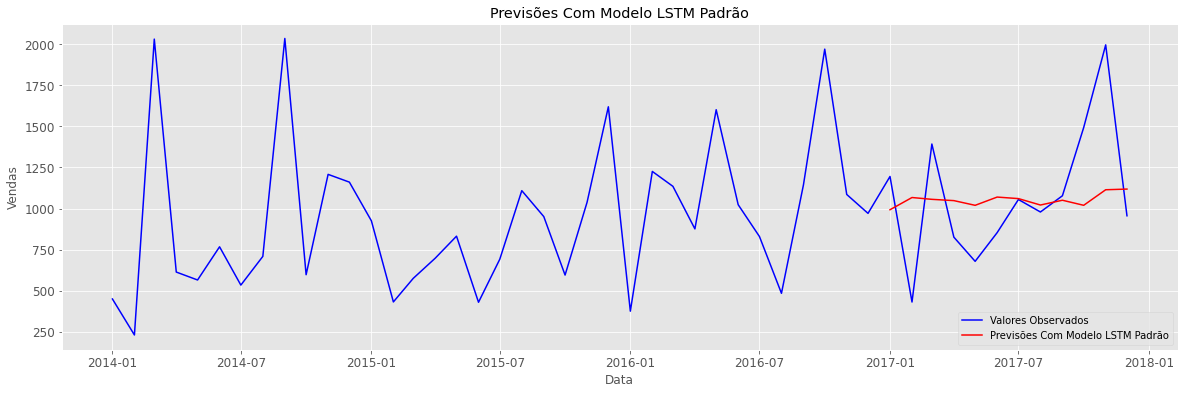

In [79]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(media_vendas_tecnologia.index, 
         media_vendas_tecnologia.values,
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(media_vendas_tecnologia[36:].index, 
         resultado_final,
         label = 'Previsões Com Modelo LSTM Padrão', 
         color = 'Red')

plt.title('Previsões Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Vamos fazer o Forecasting para 12 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [81]:
# Last date of series
media_vendas_tecnologia.index[-1]

Timestamp('2017-12-01 00:00:00', freq='MS')

In [84]:
# Create a sequence of dates from the last date of our original series
datas_para_prever_forecasting = [media_vendas_tecnologia.index[-1] + DateOffset(month = x) for x in range(0,13)]

In [85]:
#View
datas_para_prever_forecasting

[Timestamp('2017-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-03-01 00:00:00'),
 Timestamp('2017-04-01 00:00:00'),
 Timestamp('2017-05-01 00:00:00'),
 Timestamp('2017-06-01 00:00:00'),
 Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00')]

In [86]:
# Our original series is a pd.Series object
type(media_vendas_tecnologia)

pandas.core.series.Series

In [87]:
# Objects of type pd.Series give you more work to manipulate. We will convert the original series into a dataframe.
df_original = pd.DataFrame(media_vendas_tecnologia)

In [88]:
#View Data
df_original.head()

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,2031.948375
2014-04-01,613.028933
2014-05-01,564.698588


In [93]:
# Let's now create a new dataframe
# The index (date) will be the sequence of future dates
# The data column name we extracted from the original series
# ATTENTION: We are not extracting the data from the original series, only the column name
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [94]:
# View the data
# Did you understand why the NaN values? These are future dates, and we now need to include our forecasts.
data_futuras

,sales
2017-01-01,NaN
2017-02-01,NaN
2017-03-01,NaN
2017-04-01,NaN
2017-05-01,NaN
2017-06-01,NaN
2017-07-01,NaN
2017-08-01,NaN
2017-09-01,NaN
2017-10-01,NaN


In [98]:
# We use future dates to extract predictions from our model
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                         index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [99]:
# We concatenate the original series with the forecasting values of 12 month in addition to the series
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [100]:
# View the data
df_forecasting

,sales,Prediction
2014-01-01,449.041429,NaN
2014-02-01,229.787143,NaN
2014-03-01,2031.948375,NaN
2014-04-01,613.028933,NaN
2014-05-01,564.698588,NaN
2014-06-01,766.905909,NaN
2014-07-01,533.608933,NaN
2014-08-01,708.435385,NaN
2014-09-01,2035.838133,NaN
2014-10-01,596.900900,NaN


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 12 meses que correspondem aos 12 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 12 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.


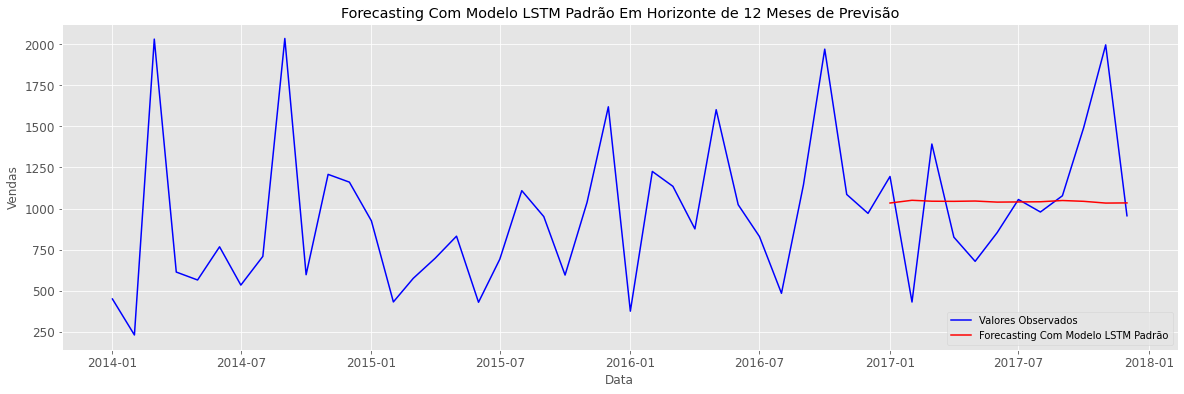

In [101]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(df_forecasting.index, 
         df_forecasting['sales'],
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(df_forecasting.index, 
         df_forecasting['Prediction'],
         label = 'Forecasting Com Modelo LSTM Padrão', 
         color = 'Red')

plt.title('Forecasting Com Modelo LSTM Padrão Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA(1,1) - AIC = 550.3, RMSE = 420.2 e MAPE = 29.58
- Aula 16 --> Modelo ARIMA(6,0,2) - AIC = 559.4, RMSE = 401.5 e MAPE = 26.58
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC = 176.74, RMSE = 425.89 e MAPE = 34.95
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC = 146.77, RMSE = 353.57 e MAPE = 30.55
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66, RMSE = 341.23 e MAPE = 32.54
- Aula 20 --> Modelo Prophet 1 - RMSE = 347.58 e MAPE = 28.53
- Aula 21 --> Modelo Prophet 2 - RMSE = 325.52 e MAPE = 26.45
- Aula 22 --> Modelo LSTM Padrão - RMSE = 395.45 e MAPE = 31.46

Nosso modelo de Deep Learning veio para a briga como um candidato de peso. Nas próximas aulas vamos otimizar o modelo e trabalhar com diferentes arquiteturas LSTM.
